In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_recall_curve, auc, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

# Load datasets
air_quality_df = pd.read_csv("data/datathon24_parte1/air_quality_gijon.csv")
meteo_df = pd.read_csv("data/datathon24_parte1/meteo_gijon.csv")
mobility_df = pd.read_csv("data/datathon24_parte1/movility_gijon.csv")
prediction_df = pd.read_csv("data/datathon24_parte2/prediction.csv")

# Merge datasets with the selected columns from air_quality_df
selected_columns = ["date", "SO2_GijonGlobal", "NO_GijonGlobal", "NO2_GijonGlobal", "CO_GijonGlobal", "PM10_GijonGlobal", "O3_GijonGlobal"]
filtered_air_quality_df = air_quality_df[selected_columns]
merged_df = filtered_air_quality_df.merge(meteo_df, on="date", how='outer').merge(mobility_df, on="date", how='outer').merge(prediction_df, on="date", how='outer')

# Convert 'date' to datetime, sort, and handle missing values
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df.sort_values('date', inplace=True)
merged_df.ffill(inplace=True)
merged_df.bfill(inplace=True)

# Normalize features and reintroduce cyclical features before normalization
scaler = StandardScaler()
exclude_cols = ["date", "ICA_PM25_target"]
features_to_scale = [col for col in merged_df.columns if col not in exclude_cols]
merged_df[features_to_scale] = scaler.fit_transform(merged_df[features_to_scale])

# Preparing x_final_prediction for December 2023
x_final_prediction_with_date = merged_df[
    (merged_df["date"] >= "2023-12-01") & (merged_df["date"] <= "2023-12-31")
]

# Ensure features are prepared similarly to the training data
x_final_prediction = x_final_prediction_with_date.drop(columns=['date', 'ICA_PM25_target'])

# Apply the same scaler transformation to x_final_prediction
x_final_prediction[features_to_scale] = scaler.transform(x_final_prediction[features_to_scale])

Best GridSearchCV XGBoost Accuracy: 0.807799442896936
              precision    recall  f1-score   support

         0.0       0.82      0.95      0.88       260
         1.0       0.76      0.44      0.56        99

    accuracy                           0.81       359
   macro avg       0.79      0.70      0.72       359
weighted avg       0.80      0.81      0.79       359

Confusion Matrix:
 [[246  14]
 [ 55  44]]
ROC AUC Score: 0.8655400155400156


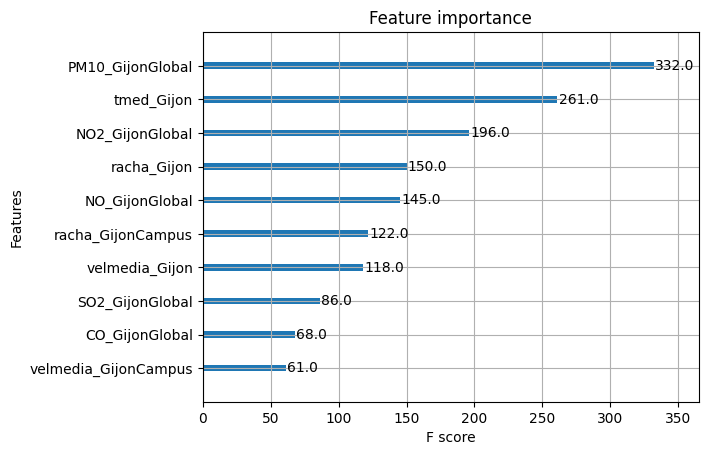

In [19]:
# Prepare X and y using all data before December 2023
X = merged_df[merged_df['date'] < '2023-12-01'].drop(columns=['ICA_PM25_target', 'date'])
y = merged_df[merged_df['date'] < '2023-12-01']['ICA_PM25_target']

# Split the data using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning with GridSearchCV
param_grid = {"max_depth": [3, 5, 7], "n_estimators": [100, 200, 300], "learning_rate": [0.01, 0.1]}
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring="accuracy", cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Use the best estimator for prediction
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

# Evaluation
print("Best GridSearchCV XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:, 1]))

# Feature Importance Visualization
plot_importance(best_xgb, max_num_features=10)
plt.show()

In [20]:
assert x_final_prediction_with_date['date'].iloc[0] == pd.to_datetime('2023-12-01'), "Start date mismatch"
assert x_final_prediction_with_date['date'].iloc[-1] == pd.to_datetime('2023-12-31'), "End date mismatch"

In [21]:
# Final prediction on unseen data (December 2023)
final_predictions = best_xgb.predict(x_final_prediction)

In [27]:
final_predictions_probs = best_xgb.predict_proba(x_final_prediction)[:, 1]
final_predictions_probs

array([0.09756026, 0.09756026, 0.09756026, 0.09372708, 0.09756026,
       0.11393295, 0.11393295, 0.09756026, 0.09271543, 0.09756026,
       0.09756026, 0.09756026, 0.09372708, 0.09756026, 0.09756026,
       0.09756026, 0.09756026, 0.09756026, 0.09756026, 0.09756026,
       0.09756026, 0.09756026, 0.09756026, 0.09756026, 0.09724355,
       0.09402791, 0.09756026, 0.09756026, 0.09756026, 0.09756026,
       0.09372708], dtype=float32)

In [22]:
final_predictions_df = x_final_prediction_with_date[['date']].copy()
final_predictions_df['prediction'] = final_predictions
final_predictions_df.to_csv('final_predictions_december_2023.csv', index=False)

final_predictions_df

,date,prediction
1795,2023-12-01,0
1796,2023-12-02,0
1797,2023-12-03,0
1798,2023-12-04,0
1799,2023-12-05,0
1800,2023-12-06,0
1801,2023-12-07,0
1802,2023-12-08,0
1803,2023-12-09,0
1804,2023-12-10,0
